In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Data loaded successfully!")
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Data loaded successfully!
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [4]:
def preprocess(image, label):
    # Normalize pixel values to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert grayscale to RGB by repeating channels
    image = tf.stack([image, image, image], axis=-1)
    # Resize to 128x128 for MobileNetV2
    image = tf.image.resize(image, [128, 128])
    return image, label

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

print("\nData preprocessing complete!")
print(f"Training batches: {len(train_ds)}")
print(f"Test batches: {len(test_ds)}")


Data preprocessing complete!
Training batches: 938
Test batches: 157


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers except last 50
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build custom model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

print("\nModel architecture:")
model.summary()


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,250 (10.02 MB)

 Trainable params: 2,220,298 (8.47 MB)

 Non-trainable params: 405,952 (1.55 MB)

In [6]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("\nModel compiled successfully!")
print("Optimizer: Adam")
print("Loss: Categorical Crossentropy")
print("Metrics: Accuracy, Precision, Recall")


Model compiled successfully!
Optimizer: Adam
Loss: Categorical Crossentropy
Metrics: Accuracy, Precision, Recall


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

print("\nStarting training...")
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=callbacks
)

model.save('mnist_model.h5')
print("\nTraining complete! Model saved as mnist_model.h5")


Starting training...
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9265 - loss: 0.2579 - precision: 0.9581 - recall: 0.9028

938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.9265 - loss: 0.2577 - precision: 0.9581 - recall: 0.9029 - val_accuracy: 0.6447 - val_loss: 3.5762 - val_precision: 0.6451 - val_recall: 0.6441 - learning_rate: 0.0010
Epoch 2/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9840 - loss: 0.0665 - precision: 0.9867 - recall: 0.9817

938/938 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.9840 - loss: 0.0664 - precision: 0.9867 - recall: 0.9817 - val_accuracy: 0.9839 - val_loss: 0.1042 - val_precision: 0.9840 - val_recall: 0.9839 - learning_rate: 0.0010
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.9888 - loss: 0.0486 - precision: 0.9902 - recall: 0.9870 - val_accuracy: 0.9793 - val_loss: 0.1325 - val_precision: 0.9797 - val_recall: 0.9792 - learning_rate: 0.0010
Epoch 4/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9872 - loss: 0.0507 - precision: 0.9891 - recall: 0.9857

938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9872 - loss: 0.0506 - precision: 0.9891 - recall: 0.9857 - val_accuracy: 0.9925 - val_loss: 0.0598 - val_precision: 0.9926 - val_recall: 0.9925 - learning_rate: 0.0010
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.9917 - loss: 0.0360 - precision: 0.9929 - recall: 0.9907 - val_accuracy: 0.9589 - val_loss: 0.2653 - val_precision: 0.9601 - val_recall: 0.9580 - learning_rate: 0.0010



Training complete! Model saved as mnist_model.h5


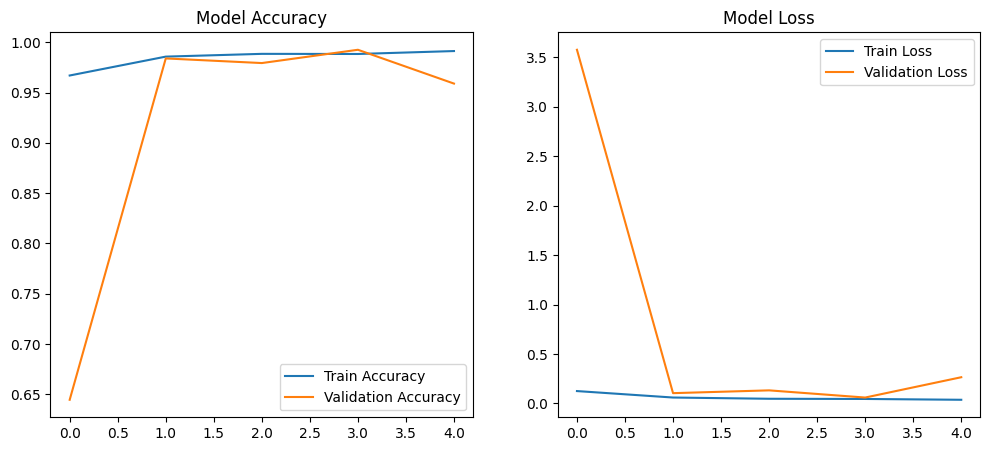

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9898 - loss: 0.0759 - precision: 0.9899 - recall: 0.9898

Test Accuracy: 0.9925
Test Precision: 0.9926
Test Recall: 0.9925
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.97      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10

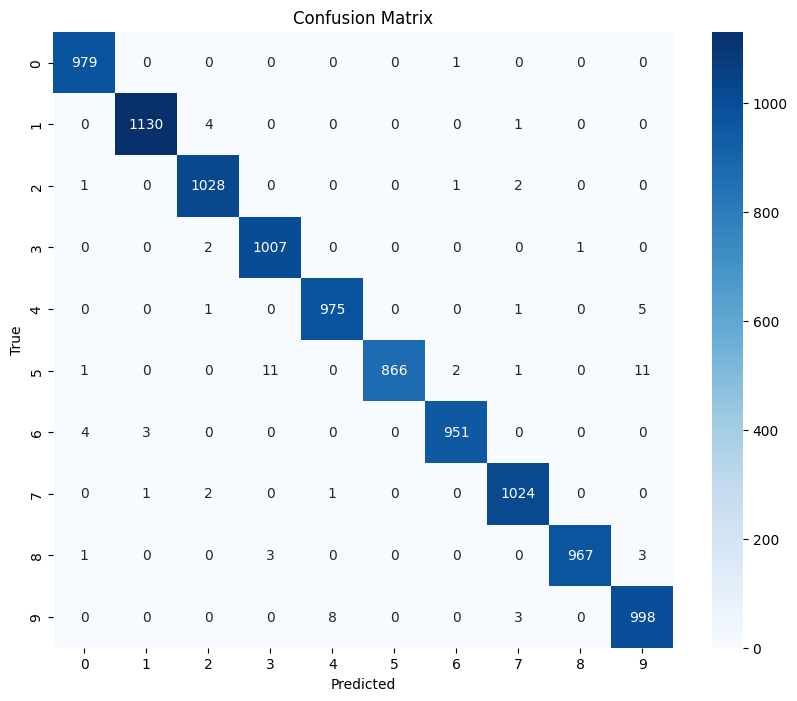

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Generate predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()